# Segment form into key and value pairs

### Imports

In [5]:
import os

import cv2
import numpy as np
import pandas as pd

from skimage import io

from time import strftime

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Users\Nikhil\anaconda3\envs\ztdl\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


### constants

In [6]:
employee_form_image="sample_data/Employee Feedback Form_1.jpg"
employee_form_image_2="sample_data/Employee Feedback Form_1.jpg"
teacher_form_image="sample_data/Teacher Feedback.jpg"

# Function to divide form into rows and columns

In [7]:
def divide_image_into_parts(image,dir_name,threshold_x, threshold_y,img_dir=False, trim=False, row=False,link=False,invert=False, draw=False):
    if link:
        image = io.imread(image)
    else:
        image = cv2.imread(image) if img_dir else image
    
    if trim:
        # trim image to remove white spaces
        temp_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_thr_temp = cv2.threshold(temp_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        coords = cv2.findNonZero(img_thr_temp)
        x, y, w, h = cv2.boundingRect(coords) 
        image = image[y:y+h, x:x+w]
    
    if row:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    cv2_thresh = cv2.THRESH_BINARY_INV if invert else cv2.THRESH_BINARY 
    
    img_thr = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 128, 255, cv2_thresh)[1]
    
    if draw:
        plt.imshow(img_thr, interpolation='nearest')
        plt.show()
    
    y_sum = np.count_nonzero(img_thr, axis=0)
    x = np.arange(y_sum.shape[0])    
    peaks = np.where(y_sum < threshold_y)[0] if invert else np.where(y_sum > threshold_y)[0]
    
    if draw:
        d = {'x': x, 'y': y_sum}
        df = pd.DataFrame(data=d)
        sns.lineplot(data=df,x="x",y="y",palette="flare")
    
    #prepending and appending to divide image froms srart to end
    peaks = np.concatenate(([0],peaks))
    peaks = np.concatenate((peaks,[(peaks[-1] + 1000)]))
    
    if draw:
        print("First element: ", peaks[0])
        print("Second element: ", peaks[1])
        print("Second last element: ",peaks[-2])
        print("last element: ",peaks[-1])

    #clean the peaks
    temp = np.diff(peaks).squeeze()
    idx = np.where(temp > threshold_x)[0]
    peaks = np.concatenate(([0], peaks[idx+1]), axis=0) + 1
    
    if draw:
        print("First element: ", peaks[0])
        print("Second element: ", peaks[1])
        print("Second last element: ",peaks[-2])
        print("last element: ",peaks[-1])
    
    try:
        os.makedirs(dir_name)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')
        
    total_img = 0
    file_name = "row_" if row else "column_"
    for i in np.arange(peaks.shape[0] -1):
        image_slice = img[:, peaks[i]:peaks[i+1]]
        if row:
            final_image = cv2.rotate(image_slice, cv2.ROTATE_90_COUNTERCLOCKWISE)
        else:
            final_image = image_slice
        cv2.imwrite(dir_name + '/' + file_name + str(i) + '.png', final_image)
        total_img += 1
    
    print("Succesfully divided the image into" , total_img, "parts")
    
    return (y_sum,peaks,total_img)

### Testing the model

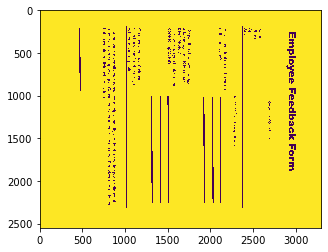

First element:  0
Second element:  0
Second last element:  3299
last element:  4299
First element:  1
Second element:  4300
Second last element:  1
last element:  4300
Cannot create a file when that file already exists
Succesfully divided the image into 1 parts


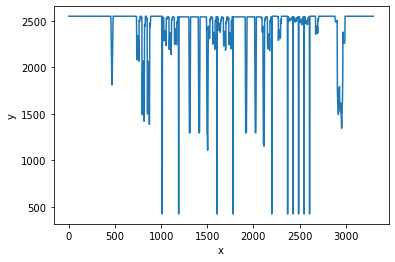

In [18]:
(y_sum,peaks,total_columns) = divide_image_into_parts(image=employee_form_image,dir_name="employee_1/rows_division",threshold_x=500,threshold_y=500,row=True, trim=True,
                                                 img_dir=True,invert=False , link=False,draw=True)